## Imports

For Colab users:

In [218]:
# !pip install cartopy

In [219]:
# data handling
import pandas as pd
import numpy  as np

# plotting 
import seaborn              as sbn
import matplotlib.pyplot    as pyp
import cartopy.crs          as ccrs
import cartopy.feature      as cfeature
import matplotlib.colors    as mcolors

# modeling
from sklearn.preprocessing      import StandardScaler
from sklearn.linear_model       import LinearRegression
from sklearn.neighbors          import KNeighborsRegressor
from sklearn.ensemble           import RandomForestRegressor
from sklearn.metrics            import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection    import cross_val_score

# **Module 4**: Regression Project

Colin Beyers\
GEOL558

# Project Overview

**Title**: Predicting Future SSTs

In this project, I want to test if a Machine Learning (ML) model can predict future Sea Surface Temperature (SST) with environmental indictors. The idea is: if I know the conditions right now, can I predict what SST will be?

There are *many* different mechanisms that force (change) SST.
- Solar radiation: the heat the ocean receives from the Sun is the primary forcing mechanism of SSTs. Due to the tilt of the Earth, solar radiation varies mostly with latitude (and changes seasonally).
- Longwave Radiation: The ocean loses heat to the atmosphere via radiation, which is affected by cloud cover and greenhouse gases.
- Latent Heat Flux: Heat loss due to evaporation, which depends on wind speed, humidity, and SST itself.
- Sensible Heat Flux: Direct heat exchange between the ocean and atmosphere, driven by temperature differences.
- Freshwater Flux: Changing the salinity of water (adding fresh water from precipitation or from rivers) can change it's temperature or how it responds to other forcings.
- Advection (vertical AND horizontal): Movement of warm or cold water by ocean currents.
- Upwelling and Downwelling: Brings cold deep water to the surface (upwelling) or pushes warm surface water downward (downwelling).
- Mixing and Turbulence: Wind-driven mixing redistributes heat within the upper ocean.
- Eddy Trapping: Mesoscale eddies "trap" heat and transports it elsewhere. 
- Bathymetry: Shallow water heats easier than deep water.
- Climate teleconnections: large-scale climate patterns like ENSO have the ability to modulate SSTs through teleconnetions.

Each of these processes modulate SST over different time and spatial scales. The choice of data product and timescales of interest will influence which forcing mechanisms are considered when choosing what features to feed into a ML model.

# Data Selection and Acquisition

For this project, I will use ECMWF (European Centre for Medium-Range Weather Forecasts) Reanalysis v5 (ERA5). This product integrates observations with models to produce hourly-to-daily global gridded data. This model was chosen because of it's integration of real data, ease of access, the volume of variables that are modeled, and it's popularity among researchers. However, all the forcing mechanisms discussed above are not modeled in the ERA5 product. Below, I will justify my decision on what variables in include and which I exclude.

ERA5 data can be easily access with an API call.

**WARNING**: The code below is just an example of how I accessed ERA5 data. There is no need to run the cell.

In [220]:
import cdsapi

dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "2m_temperature"
    ],
    "year": ["2021"],
    "month": [
        "01"
    ],
    "day": [
        "01"
    ],
    "time": [
        "00:00"
    ],
    "data_format": "netcdf",
    "download_format": "unarchived"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-02-18 23:37:07,499 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-18 23:37:07,500 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-18 23:37:08,320 INFO Request ID is 205fe5a5-d103-4db1-9ad8-effb7ab33155


KeyboardInterrupt: 

I collected data for the entire year of 2021 for the following data variables:
- Sea Surface Temperature (SST)
- Net Downward Radiation (NDR): The total radiation from the Sun at the ocean surface; takes into account cloud coverage and other atmospheric processes that could influence surface radiation
- Precipitation (precip)
- Evaporation (evap)
- 2m Temperature (T2m): The temperature at 2 meters above the surface
- 10m Winds (u10/v10): commonly used as the surface wind values

With these variables, the following processes that modulate SST are accounted for:\
✅ Solar radiation: NDR\
✅ Latent Heat Flux: evap and u10/v10\
✅ Sensible Heat Flux: T2m and SST\
✅ Freshwater Flux: precip (*most* freshwater fluxes in the ocean are driven by rain; rivers only matter in coastal regions)\
✅ Upper-ocean Mixing: u10/v10 winds

For this project, what I am really trying to do is predict how much SST will *change* from the current time step to a future time step. The model will know what the SST is at the current time step, so what it needs to be told is what processes primarily drive changes in SST. The following processes are not directly described by the chosen variables, and I give a justification for each as to why I think it's a reasonable decision.\
\
❌ Longwave radiation: compared to solar radiation and heat fluxes, longwave radiation just isn't a primary driver of changes to SST because it happens too slow. It is also possible that given SST(t=0) and SST(t=i) that a ML model might be able to just learn this pattern on it's own.\
❌ Upwelling/Downwelling: This processes is really only significant for coastal regions, where as I am considering all regions of the ocean. It is also a very slow process, varying on seasonal timescales.
❌ Eddy trapping: the rate at which heat is transported via eddy trapping depends in it's translation speed. Eddies translate at a rate of O(1 km) per day. The grid cell size for the ERA5 data product is ~30 km. While eddies may redistribute heat around a grid cell, they are not a driving force in large-scale heat transport.\
❌ Advection: there are many reasons to exclude advection for this project. 
1) Practical considerations: ERA5 does not model ocean currents. Therefore, I would have to collect currents from a different source (AVISO data product, HYCOM ocean model, etc.). Combining this with the ERA5 data would likely require a complicated regridding process. 
2) Ocean currents would also not likely fit well into the `Pandas` `Dataframe` data structure. Ocean currents at one location would advect heat from that location TO another location. For this project, an entry into the final `Dataframe` will be the SST, precip, NDR, etc. at one location in space and time. Providing the currents at that space and time would not actually be informative to predict the SSTs at that same point in the future.
3) Finally, a simple scaling argument can be made to show that currents are not a driving force in distributing heat over short time scales (days). Currents have a speed of O(10 cm/s). Per day, this comes out to O(1 km/day). Again, given the size an ERA5 grid cell (30 km), currents may contribute to changes of SST within the grid cell, but to not contribute to advection of heat from one grid cell to another over short time scales.

❌ Bathymetry: This again is only really relevant for coastal regions, where the depth get's shallow enough to meaningfully modulate how quick the ocean can heat/cool.\
❌ Teleconnections: these are only relevant over seasonal+ timescales.

For this project, I will try to use ML to predict *surface* SSTs over *short time scales* (days).

# Data Preprocessing

Some features had a different temporal resolutions.
- SST: daily resolution
- Everything else: 3-hr resolution (native is 1-hr; I downloaded every 3-hr to save space but also capture daily cycles)

First, all variables needed to have the same daily resolutions. Different variables called for different resampling techniques.
- Extensive variables (`precip`, `evap`): daily sum represents the total amount of flux per day
- Intensive Variables (`NDR`, `u10/v10`, `T2m`): daily average gets rid of daily cycles but captures day-to-day trends

For this project, each row of my `Dataframe` will be the SST, future SSTs (from 1 to 7 days out), and environmental variables (evap, precip, NDR, etc.). he raw global gridded data for the entire year of 2021 was > 10 GB. If this were converted into a `Dataframe` as described above, there would be 100's of millions of entries, which is a bit overkill. Plus, the max file size that can be uploaded to GitHub is 2 GB. So, this dataset needed to be reduced. There are several ways this could have been done:
- Choosing a sample domain, or
- Choosing a sample time frame.
While these methods would have been simple, it's possible that these methods would have led to poor generalization. An interesting goal to pursue for this project would be to tran a ML on a representative subset of ERA5 data and then see if it would be able to predict future SSTs for the entire global domain. Using the subset techniques before would have likely introduced spatial or temporal autocorrelation biases. Instead, I chose to extract 125,000 (about 1% of the size of the original dataset) points in space and time based off of the distribution of SSTs for the entire space and time domain. Then ensures that the `Dataframe` is representative of the entire years worth of data.

**COMMENT**: sorry I didn't have time to put in this figure. If you look at the distribution below though, just imagine the bin on the left being really really tall.

The above distribution has an unusual peak at the lowest bin. There are several reasons this may be:
1) The temperature of this bin, ~ 271 K (-2 C), is just about the coldest seawater can get before freezing. Any values that drop below this would mean the seawater would become ice, and no longer be seawater (and therefore, don't have an SST).
2) These SSTs are likely from grid cells in polar regions. SSTs are known to change less at the poles than they do at the mid-latitudes or tropics, so it may be that throughout time, SSTs in the poles hover around the same value.
3) The model may be performing poor in polar regions because there is less data from these regions to constrain the model 
4) The Gaussian grid used by ERA5 means that grid cells at the poles have a smaller area than those at the mid-latitudes or tropics. This means that there are more or similar amounts of grid cells representing a smaller area, meaning that the SSTs here may be oversampled.

To overcome this, I chose to simply chop the data and only consider between 60 S to 60 N to avoid the dataset being dominated by polar grid cells. This adjusts the distribution to look like the below. Finally, SSTs where chosen from this distribution and were constructed into a `Dataframe` as described above.

In [221]:
url = 'https://raw.githubusercontent.com/colinbeyers/GEOL558-submissions/refs/heads/main/module_4/ERA5-lat%2Clon%2Ctime%2CSST%2Cenv_vars%2CSST(t%2Bi)-2021_small.csv'
df = pd.read_csv(url)

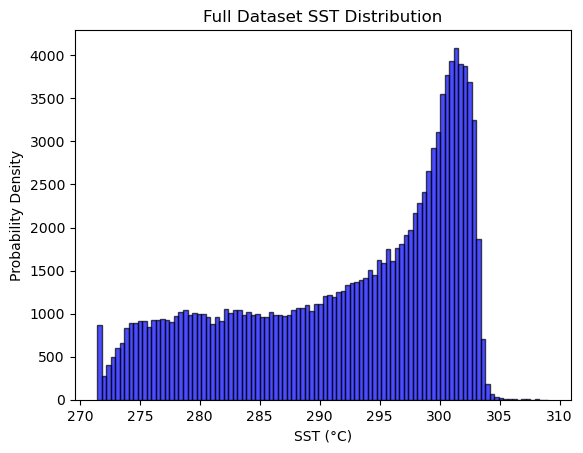

In [222]:
# Plot the histogram of full SST distribution
pyp.hist(df['SST'].values, bins=100, alpha=0.7, color='b', edgecolor='black')
pyp.xlabel("SST (°C)")
pyp.ylabel("Probability Density")
pyp.title("Full Dataset SST Distribution")
pyp.show()

I accidentally summed `NDR` when preprocessing, so I will divide by 8 (8 3-hr time steps per day) to get the mean.

In [223]:
df['NDR'] = df['NDR'] / 8

# Exploratory Data Analysis

While this `Dataframe` no longer contains the spatial and temporal structure of the original gridded dataset, it is a statistical representation of that dataset.

In [224]:
# insert movie here if I have time

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   time      125000 non-null  object 
 1   lat       125000 non-null  float64
 2   lon       125000 non-null  float64
 3   SST       125000 non-null  float64
 4   NDR       125000 non-null  float64
 5   precip    125000 non-null  float64
 6   evap      125000 non-null  float64
 7   T2m       125000 non-null  float64
 8   u10       125000 non-null  float64
 9   v10       125000 non-null  float64
 10  SST(t+1)  125000 non-null  float64
 11  SST(t+2)  125000 non-null  float64
 12  SST(t+3)  125000 non-null  float64
 13  SST(t+4)  125000 non-null  float64
 14  SST(t+5)  125000 non-null  float64
 15  SST(t+6)  125000 non-null  float64
 16  SST(t+7)  125000 non-null  float64
dtypes: float64(16), object(1)
memory usage: 16.2+ MB


In [226]:
df.describe()

,lat,lon,SST,NDR,precip,evap,T2m,u10,v10,SST(t+1),SST(t+2),SST(t+3),SST(t+4),SST(t+5),SST(t+6),SST(t+7)
count,125000.000000,125000.000000,125000.000000,1.250000e+05,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000,125000.000000
mean,-7.749150,192.894530,292.090542,6.402316e+05,0.001105,-0.001221,290.856538,0.106111,0.152412,292.090869,292.090777,292.090242,292.090520,292.090500,292.090855,292.091106
std,33.624213,97.569726,9.185909,3.039599e+05,0.002532,0.000846,9.063287,6.261268,4.646259,9.185333,9.184172,9.184869,9.185267,9.184883,9.184587,9.184729
min,-60.000000,0.000000,271.458000,2.384000e+03,0.000000,-0.012287,240.272610,-21.129585,-19.432678,271.459230,271.459470,271.337160,271.312740,271.081540,270.919680,270.884280
25%,-37.500000,118.000000,284.665040,3.980780e+05,0.000065,-0.001699,283.875117,-5.114921,-2.943700,284.658450,284.658145,284.644473,284.658637,284.664240,284.663755,284.669560
50%,-10.250000,194.750000,294.776485,6.915040e+05,0.000284,-0.001157,293.418070,-0.699807,0.261457,294.776245,294.766850,294.767215,294.777830,294.766975,294.766600,294.766230
75%,19.000000,271.750000,300.209780,8.890820e+05,0.001009,-0.000613,298.949055,4.772087,3.421205,300.209043,300.212650,300.205382,300.206113,300.206800,300.205080,300.201480
max,60.000000,359.750000,309.042720,1.366688e+06,0.086883,0.002028,311.454160,20.408880,19.444760,308.367430,308.534900,308.812260,308.407230,308.597900,308.523200,308.756600


While the goal  of this data sampling technique was the make the SSTs representative of the SSTs in the original dataset, a good spatial distribution is also important.

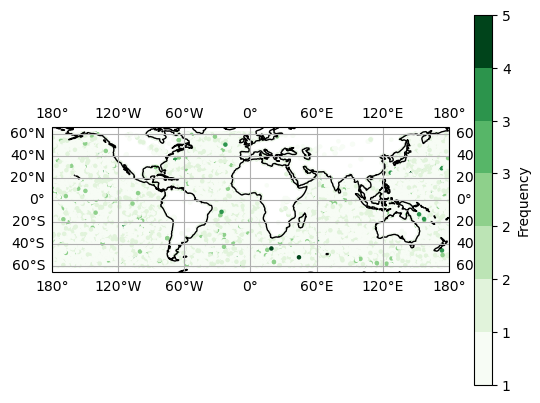

In [227]:
# Count occurrences of each (lon, lat) pair
count = df.groupby(["lon", "lat"])["lon"].transform("count")

# Define discrete bins for frequency values
bins = np.linspace(count.min(), count.max(), num=8)  # Adjust the number of bins if needed
norm = mcolors.BoundaryNorm(bins, ncolors=8)  # 5 discrete colors

# Custom colormap (different shades of purple)
cmap = pyp.get_cmap("Greens", 8)  # "Purples" colormap with 5 discrete levels

# Create figure and axis with PlateCarree projection
fig, ax = pyp.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Scatter plot colored by frequency with discrete colormap
sc = ax.scatter(df["lon"], df["lat"], c=count, cmap=cmap, norm=norm, s=5, transform=ccrs.PlateCarree())

# Add discrete colorbar
cbar = pyp.colorbar(sc, boundaries=bins, ticks=bins, label="Frequency")
cbar.ax.set_yticklabels([f"{int(b)}" for b in bins])  # Format labels as integers

pyp.show()

This data has a good spatial distribution.

## Feature Correlations

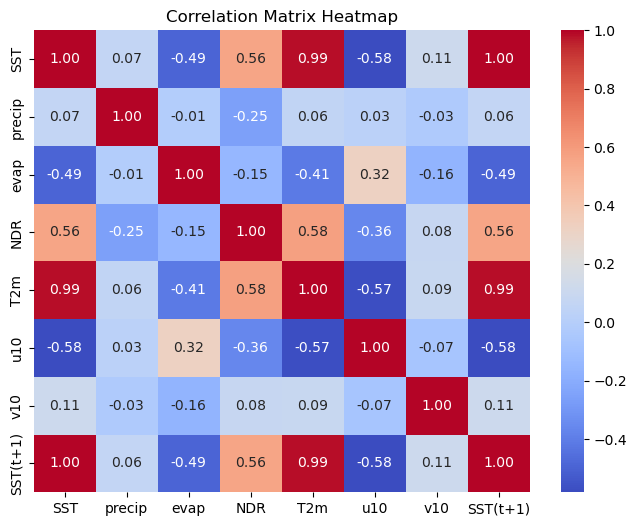

In [228]:
corr_matrix = df[['SST', 
                  'precip', 
                  'evap', 
                  'NDR',
                  'T2m',
                  'u10',
                  'v10',
                  'SST(t+1)']].corr()

# Plot the heatmap
pyp.figure(figsize=(8, 6))
sbn.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
pyp.title('Correlation Matrix Heatmap')
pyp.show()

SST one day out from the current timestep (SST(t+1)) is nearly 100% correlated with the SST from the day before. This is not surprising as SST does not change by much day-to-day. It is also highly correlated with the air temperature, and to a lesser degree the NDR. It is negatively correlated with evaporation, meaning that as more water evaporates, SST increases (not surprising - more evaporation usually means it's hotter!). The same is true for u10 - as there is more wind, the ocean responds by cooling. Interestingly, there is very little correlation with v10. This is likely because u-winds (in the x-direction) are winds like the trade winds, which have a much stronger global influence on large-scale ocean dynamics.

## Box and Whisker Plots

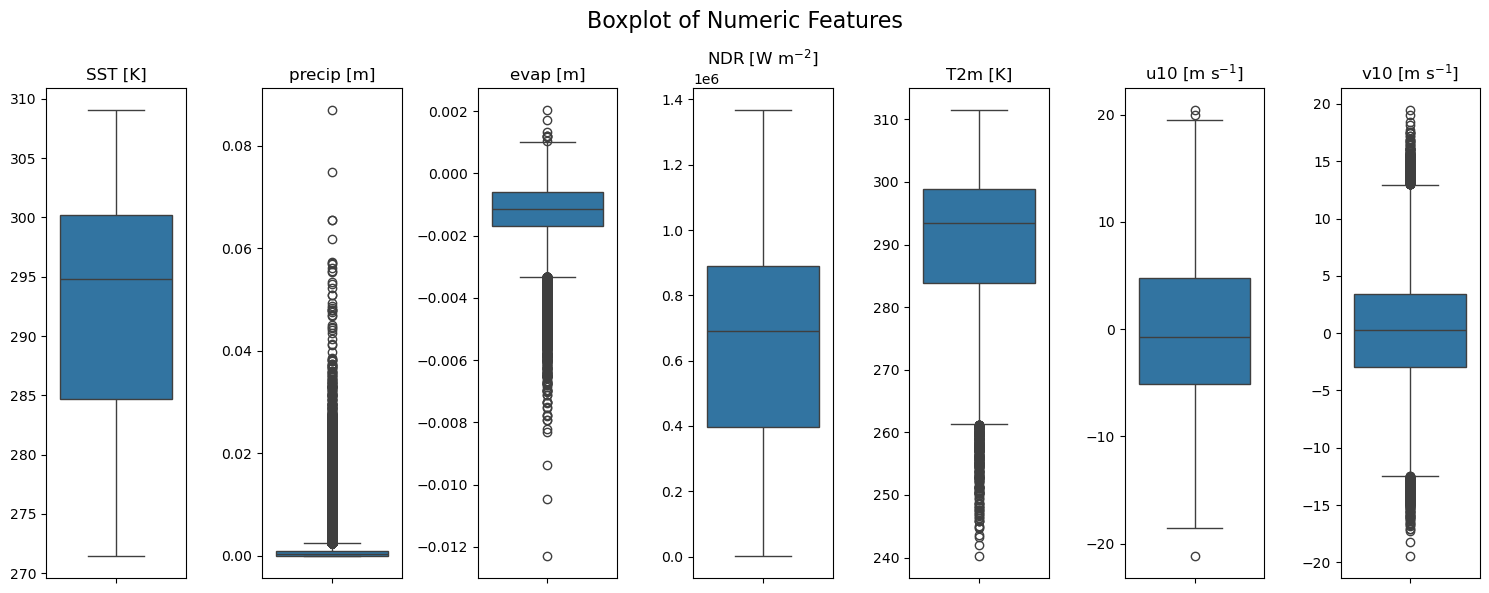

In [229]:
features    = ['SST', 'precip', 'evap', 'NDR', 'T2m', 'u10', 'v10']
units       = ['K', 'm', 'm', 'W m$^{-2}$', 'K', 'm s$^{-1}$', 'm s$^{-1}$']

fig, axes = pyp.subplots(nrows=1, ncols=len(features), figsize=(15, 6))

for ax, feature, unit in zip(axes, features, units):
    sbn.boxplot(data=df[feature], ax=ax)
    ax.set_title(f'{feature} [{unit}]')
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Boxplot of Numeric Features', fontsize=16)

pyp.tight_layout()
pyp.subplots_adjust(top=0.85)

pyp.show()

# Feature Engineering

## Spatial split

To make independent training and testing data, I will use a spatial split. I will not include any temporal splitting. I think this is an appropriate choice considering I'm actually trying to take advantage of the temporal autocorrelation between past and future SSTs.

In [236]:
df['delta_SST(t+1)'] = df['SST(t+1)'] - df['SST']

In [237]:
# Define the number of bins or use a different approach to define bin edges
lat_bins = np.linspace(df['lat'].min(), df['lat'].max(), num=11)  # 10 spatial bins
lon_bins = np.linspace(df['lon'].min(), df['lon'].max(), num=11)  # 10 spatial bins

# Use np.digitize to bin the latitudes and longitudes
df['lat_bin'] = np.digitize(df['lat'], lat_bins)
df['lon_bin'] = np.digitize(df['lon'], lon_bins)

# Now, randomly choose spatial bins for training and testing
# Let's say we want to use 80% of the spatial bins for training and 20% for testing

# Identify unique (lat_bin, lon_bin) combinations
unique_bins = df[['lat_bin', 'lon_bin']].drop_duplicates()

# Randomly select 80% of these bins for training and 20% for testing
train_bins = unique_bins.sample(frac=0.75, random_state=10240)
test_bins = unique_bins.loc[~unique_bins.index.isin(train_bins.index)]

# Assign the training and testing data based on spatial bins
df_train = df[df[['lat_bin', 'lon_bin']].apply(tuple, axis=1).isin(train_bins.apply(tuple, axis=1))]
df_test = df[df[['lat_bin', 'lon_bin']].apply(tuple, axis=1).isin(test_bins.apply(tuple, axis=1))]

# Check the number of points in train and test sets
print(f"Training set size: {df_train.shape}")
print(f"Testing set size: {df_test.shape}")
print(f"Total dataset size: {df.shape}")

# Drop the bin columns after the split (optional)
df_train = df_train.drop(columns=['lat_bin', 'lon_bin'])
df_test = df_test.drop(columns=['lat_bin', 'lon_bin'])

Training set size: (101100, 20)
Testing set size: (23900, 20)
Total dataset size: (125000, 20)


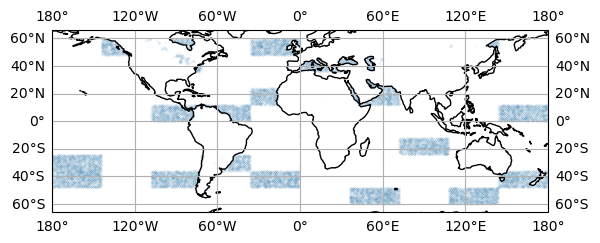

In [238]:
# Create figure and axis with PlateCarree projection
fig, ax = pyp.subplots(subplot_kw={"projection": ccrs.PlateCarree()})

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Scatter plot colored by frequency with discrete colormap
sc = ax.scatter(df_test["lon"], df_test["lat"], s=0.001, transform=ccrs.PlateCarree())

pyp.show()

When I first tried training some models, what I saw (especially from the Random Forests model) was that past SST was the dominant feature for predicting future SST. This does make sense, but the other features didn't seem to matter to the model at all. While my R² scores were really high, my MAEs were greater than the mean change in temperature between the past and future state (SST really doesn't change much day-to-day). To adjust for this, I will instead make the target the change in the future time step SST and the current time step SST. This should avoid inflating the R² and make the MAEs more interpretable.

In [239]:
# df['delta_SST(t+1)'] = df['SST(t+1)'] - df['SST']

In [240]:
target = ['delta_SST(t+1)']

In [241]:
X_train = df_train[features]
X_test  = df_test[features]
y_train = df_train[target]
y_test  = df_test[target]

## Scale the data

Scaling separately avoids data leakage.

In [242]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)

# First Pass

## Linear Regression

Linear regression is a great model to start out on because it's simple and easy to interpret.

In [243]:
model = LinearRegression()

model.fit(X_train, y_train)

y_train_pred    = model.predict(X_train)
y_test_pred     = model.predict(X_test)

In [244]:
r2_train    = r2_score(y_train, y_train_pred)
r2_test     = r2_score(y_test, y_test_pred)
rmse_train  = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test   = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_train   = mean_absolute_error(y_train, y_train_pred)
mae_test    = mean_absolute_error(y_test, y_test_pred)

print("Training R²:", r2_train)
print("Testing R²:", r2_test)
print("Training RMSE:", rmse_train)
print("Testing RMSE:", rmse_test)
print("Training MAE:", mae_train)
print("Testing MAE:", mae_test)

Training R²: 0.04682593380124889
Testing R²: 0.04869918044940502
Training RMSE: 0.21010942654597525
Testing RMSE: 0.22077992867555252
Training MAE: 0.14183083684959905
Testing MAE: 0.14757522683705826


In [245]:
np.mean(np.abs(df['delta_SST(t+1)'].values))

0.14684295079999998

These scores are rough! I talk more about what each score means in the discussion section. What to note here:
- Very poor R², even for training.
- MAE is within the different between the past SST and the future SST.

I'll think more about cross validation in my final version.

In [246]:
# Initialize your model (e.g., Linear Regression)
model = LinearRegression()

# Perform cross-validation (e.g., 5 folds)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert MSE to RMSE (Root Mean Squared Error)
rmse_scores = np.sqrt(-cv_scores)

# Print out the results
print(f"Cross-validated RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean()}")
print(f"Standard Deviation of RMSE: {rmse_scores.std()}")

Cross-validated RMSE scores: [0.20924938 0.21172013 0.20992879 0.20799363 0.2117304 ]
Mean RMSE: 0.21012446713676453
Standard Deviation of RMSE: 0.0014470447307073503


# K-Nearest Regressor (KNR)

This model is slightly more complex than linear regression.

In [247]:
# 1. Initialize the KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can experiment with n_neighbors

# 2. Fit the model to the training data
knn.fit(X_train, y_train)

# 3. Predict on the training and testing datasets
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [248]:
# 4. Calculate performance metrics for training and testing
train_r2    = r2_score(y_train, y_train_pred)
test_r2     = r2_score(y_test, y_test_pred)
train_rmse  = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse   = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae   = mean_absolute_error(y_train, y_train_pred)
test_mae    = mean_absolute_error(y_test, y_test_pred)

# 5. Print the results
print(f"Training R²:   {train_r2}")
print(f"Testing R²:   {test_r2}")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE:  {test_rmse}")
print(f"Training MAE:  {train_mae}")
print(f"Testing MAE:   {test_mae}")

Training R²:   0.2764003436162995
Testing R²:   -0.11393960577745021
Training RMSE: 0.18306638456341023
Testing RMSE:  0.23890843091289696
Training MAE:  0.1272083661721067
Testing MAE:   0.1660422446025102


Unfortunately, a negative R² indicates that the model is performing worse than a simple baseline model (such as predicting the mean of the target variable for all data points). While the errors are not bad, the predictions frankly suck.

## Random Forests

Random Forests is a big step up from both the previous models. 

**WARNING**: This cell takes a few minutes to run.

In [249]:
# 3. Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# 4. Predictions and Evaluation

# Predictions on training data
y_train_pred = rf.predict(X_train)

# Predictions on test data
y_test_pred = rf.predict(X_test)

/Users/colin_beyers@mines.edu/miniconda3/envs/test/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [250]:
# Calculate R², RMSE, and MAE for training and testing data
train_r2    = r2_score(y_train, y_train_pred)
test_r2     = r2_score(y_test, y_test_pred)
train_rmse  = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse   = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae   = mean_absolute_error(y_train, y_train_pred)
test_mae    = mean_absolute_error(y_test, y_test_pred)

# Print evaluation metrics
print(f"Training R²: {train_r2}")
print(f"Testing R²: {test_r2}")
print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Testing MAE: {test_mae}")

Training R²: 0.8664836884247701
Testing R²: -0.025059187024192964
Training RMSE: 0.07863693752739123
Testing RMSE: 0.2291791605949614
Training MAE: 0.05318188661523244
Testing MAE: 0.15704365370292883


These results show much more promise during training, but low skill for generalizing. This is workable though!

In [251]:
# 5. Feature Importance (optional)
importances = rf.feature_importances_
for feature, importance in zip(features, importances):
    print(f"Feature: {feature}, Importance: {importance}")

Feature: SST, Importance: 0.11652631868657475
Feature: precip, Importance: 0.13395408037129947
Feature: evap, Importance: 0.17810579877207036
Feature: NDR, Importance: 0.15433782611175478
Feature: T2m, Importance: 0.12053451597622294
Feature: u10, Importance: 0.14996444765856148
Feature: v10, Importance: 0.14657701242351606


These importances are really not that trustworthy right now because of how the model is performing. It shows that no feature is much more important than the others. I would expect that one of the features should be more dominant.

# Discussion

*1. Which method did you like the most?*

While no base model performed well (like, at all), the Random Forests (RF) model shows the most promise for hyperparameter tuning. This is definitely a complicated problem! I think an RF model is really the only choice that I tried so far that has enough tuning options to get a working model spun up. There are more complicated regressors I could try, which I would explore if future RF models do not perform well.

*2. Which method did you like the least?*


I liked KNR the least. While it ran quickly, it's R² was laudable. Even though none of these models were tuned, baseline models can still usually show how appropriate they are for the problem. A model that is struggling to make any meaningful predictions is likely not one worth investing more time into.

*3. How did you score these supervised models?*

For each model, I used the following metrics. I calculated them for the training and testing sets of data, to assess if the model was generalizing well or not.

**R² (Coefficient of Determination)**: The proportion of the variance in the target variable that is explained by the model. It's range is from 0 to 1 (higher is better). A higher R² indicates a better fit of the model to the data, but it may be misleading if the model is overfitting.

**RMSE (Root Mean Squared Error)**: The square root of the average squared differences between predicted and actual values. It's range is from 0 to ∞ (lower is better). RMSE gives an idea of the magnitude of error in the model’s predictions. It is more sensitive to larger errors because it squares the residuals.

**MAE (Mean Absolute Error)**: The average of the absolute differences between predicted and actual values. It's range is from 0 to ∞ (lower is better). MAE provides an average size of errors, making it easier to interpret. Unlike RMSE, it does not penalize large errors as much. It's units are the same as the target, which makes it very interpretable, especially if you're familiar with your data.

*4. Did the output align with your geologic (oceanographic) understanding?*

So far, no. Even though they are untuned, the model's are performing worse than I thought they would. I'm hoping with some hyperparameter tuning, my results will be stronger. What I'm hoping is that the features I am providing the model with are the most physically significant to predict what SST will be in the future, but I may not be considering everything I need to. It may also be the case that conditions like wind or solar forcing might not have an effect the day after, but maybe 3 days or 5 days after, because the ocean responds slowly to external forcing. Luckily, my dataset already has SSTs for 7 days out.

*5. What did you want to learn more about?*


In my final version, I want to explore how different time lags might produce better or worse predictions. I also want to explore the role of hyperparameter tuning in my model's performance. Finally, if I get a model that is performing within acceptable errors, I want to see if I can pass a model the full gridded product at one time step and see if it can predict the SSTs at a later timestep, similar to what I imagine would be done if this model was used in the real world.

*6. Did you pre-process your data? Do all models require pre-processing?*

Yes, I had a *lot* of preprocessing to do, which is described in much depth in my Data Preprocessing section. The second question I already answered in module 3.